# Trend is your friend

El objectivo de este ejercicio es escribir una funcion llamada **trend_signal()** que entregue una recomendacion de compra o venta basado la posicion de tres medias moviles de distinto largo de ventana.

## 1. Preambulo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Importar nuestra data
meta = pd.read_csv('etf_list.csv')
meta = meta.set_index('ticker')
rt_etf = pd.read_pickle('etf_er.pkl')

meta

,name,asset,region,aesthetic
ticker,,,,
IYJ,iShares Dow Jones U.S. Industrial,Equities,United States,U.S. Industrial
IYC,iShares Dow Jones U.S. Consumer Services,Equities,United States,U.S. Consumer Services
IYM,iShares Dow Jones U.S. Basic Materials,Equities,United States,U.S. Basic Materials
IYF,iShares Dow Jones U.S. Financial Sector,Equities,United States,U.S. Financial Sector
IYK,iShares Dow Jones U.S. Consumer Goods,Equities,United States,U.S. Consumer Goods
IYT,iShares Dow Jones Transportation Average,Equities,United States,U.S. Transportation
IYG,iShares Dow Jones U.S. Financial Services,Equities,United States,U.S. Financial Services
IYW,iShares Dow Jones U.S. Technology,Equities,United States,U.S. Technology
IYZ,iShares Dow Jones U.S. Telecommunications,Equities,United States,U.S. Telecommunications


In [2]:
# Por medio de for-loops...
columnas_bonitas = []

for nemo in rt_etf.columns:
    nueva_etiqueta = meta.loc[nemo, 'aesthetic']
    columnas_bonitas.append(nueva_etiqueta)

# O en una sola linea!
columnas_bonitas = [meta.loc[nemo, 'aesthetic'] for nemo in rt_etf.columns]
    
rt_etf.columns = columnas_bonitas
print(rt_etf)

            U.S. Basic Materials  U.S. Consumer Goods  U.S. Consumer Services  \
date                                                                            
1996-03-19                   NaN                  NaN                     NaN   
1996-03-20                   NaN                  NaN                     NaN   
1996-03-21                   NaN                  NaN                     NaN   
1996-03-22                   NaN                  NaN                     NaN   
1996-03-25                   NaN                  NaN                     NaN   
...                          ...                  ...                     ...   
2022-03-25              0.010186             0.010303               -0.001610   
2022-03-28             -0.010743            -0.000050                0.016797   
2022-03-29              0.000933             0.005999                0.022334   
2022-03-30              0.002463            -0.001292               -0.012668   
2022-03-31             -0.00

Para trabajar con medias moviles, necesitamos precios, no retornos...

\begin{align}
P_{T} \propto \Pi^{T}_{t=1}(1 + r_{t})
\end{align}

In [3]:
px_etf = rt_etf.add(1).cumprod()
print(px_etf.tail())

            U.S. Basic Materials  U.S. Consumer Goods  U.S. Consumer Services  \
date                                                                            
2022-03-25              4.571470             5.467435                4.319042   
2022-03-28              4.522360             5.467162                4.391587   
2022-03-29              4.526578             5.499959                4.489668   
2022-03-30              4.537726             5.492852                4.432793   
2022-03-31              4.506090             5.476454                4.355025   

            U.S. Energy  U.S. Financial Sector  U.S. Financial Services  \
date                                                                      
2022-03-25     2.879245               2.698572                 2.434005   
2022-03-28     2.808153               2.692355                 2.427696   
2022-03-29     2.800633               2.709763                 2.464499   
2022-03-30     2.831394               2.682407           

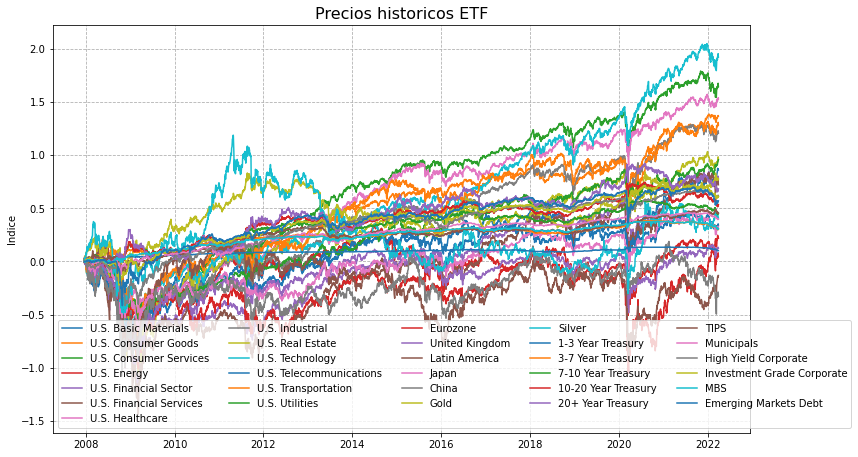

In [4]:
# Veamos como se ven estos precios
muestra = px_etf.copy().dropna()  # Solo filas con datos completos
muestra = muestra.div(muestra.iloc[0])  # Rebase
muestra = muestra.apply(np.log)

fig, ax = plt.subplots(figsize=(12.5, 7.5))
ax.plot(muestra)
ax.set_title('Precios historicos ETF', fontsize=16)
ax.set_ylabel('Indice')
ax.legend(muestra.columns, ncol=5)
ax.grid(ls='--')
plt.show()

## 2. Media Movil Simple

Una media movil simple (SMA) es calculada sumando el precio de cierre de un activo durante un numero de periodos de tiempo (largo de la ventana) y dividir esta suma por el numero de periodos. Por ejemplo, una media movil simple en una ventana de 10 dias es calculada como:

\begin{align}
  SMA(10)_{t} = \frac{P_{t} + P_{t-1}+ P_{t-2} + P_{t-3} + P_{t-4} + P_{t-5} + P_{t-6} + P_{t-7} + P_{t-8} + P_{t-9}}{10}
\end{align}

donde $P_{t}$ es el precio del activo en el periodo $t$.

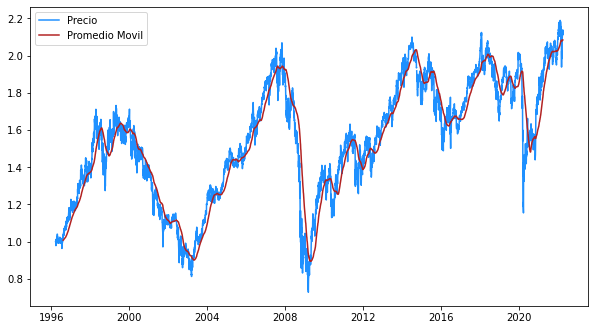

In [5]:
serie_de_tiempo = px_etf['United Kingdom'].copy()  # Nuestro pandas Series con el que vamos a probar
media_movil = pd.Series(index=serie_de_tiempo.index, dtype=float)
ventana = 100  # Numero de periodos de la media movil simple

for dt in media_movil.index[ventana:]:
    posicion_termino = media_movil.index.get_loc(dt)  # Fin de la ventana
    posicion_inicio = posicion_termino - ventana
    fecha_inicio = media_movil.index[posicion_inicio]
    fecha_termino = media_movil.index[posicion_termino]
    
    # Muestreo
    sub_muestra = serie_de_tiempo[fecha_inicio:fecha_termino]
    sma = sub_muestra.mean()
    
    # Guardo los resultados
    media_movil[dt] = sma

# Mi primera media movil!
fig, ax = plt.subplots(figsize=(10, 5.5))
ax.plot(serie_de_tiempo, color='dodgerblue')
ax.plot(media_movil, color='firebrick')
ax.legend(['Precio', 'Promedio Movil'])
plt.show()

## 3. Funcion

### 3.1 Objectivo
La estrategia de analisis tecnico que vamos a crear va a seguir la siguiente logica:

\begin{equation*}
    \text{Posicion} =
      \begin{cases}
        \text{Largo}, & SMA(R) > SMA(I) \quad \& \quad SMA(R) > SMA(L) \\
        \text{Corto}, & SMA(R) < SMA(I) \quad \& \quad SMA(R) < SMA(L) \\
        \text{Cerrado}, & EOC \\
      \end{cases}
\end{equation*}

donde $R$, $I$, y $L$ son los numeros de observaciones utilizadas en las ventana rapida, intermedia, y lenta, respectivamente y se cumple que:

\begin{align}
L > I > R
\end{align}

Ademas de recibir estos tres parametros, la funcion debe recibir la serie de tiempo de precios a analizar. La funcion debe **retornar solo un numero** sugiriendo posicion larga (1), cerrada (0), o corta (-1) en base a la posicion de las medias moviles, asumiendo que el valor mas reciente de la serie corresponde a $t$.

### 3.2 Inputs
- **precios**: pandas Series. Contiene la serie de tiempo con los precios a analizar. 
- **rapida**: int. Numero de observaciones de la ventana rapida (R).
- **intermedia**: int. Numero de observaciones de la ventana intermedia (I).
- **lenta**: int. Numero de observaciones de la ventana lenta (L).

### 3.3 Outputs
- **posicion**: int. 1 si el cruce de medias moviles sugiere estar largo, -1 si el cruce de medias moviles sugiere estar corto, 0 si el cruce de medias moviles sugiere estar cerrado.

| index      | values   |
|:----------:|:--------:|
| 06/29/2021 | 4,291.80 | 
| 06/30/2021 | 4,297.50 | 
| 07/01/2021 | 4,319.94 | 
| 07/02/2021 | 4,352.34 | 
| 07/06/2021 | 4,343.54 | 
| 07/07/2021 | 4,358.13 |
| 07/08/2021 | 4,320.82 | 
| 07/09/2021 | 4,369.55 |
| 07/12/2021 | 4,384.63 | 
| 07/13/2021 | 4,369.21 | 
| 07/14/2021 | 4,374.30 | 
| 07/15/2021 | 4,360.03 | 
| 07/16/2021 | 4,327.16 |


Mientras que definimos **rapida** (R), **intermedia** (I), y **lenta** (L) como 2, 5, y 10, respectivamente. Entonces, la funcion va a calcular:

\begin{align*}
SMA(R) &= \frac{4,327.16 + 4,360.03}{2} = 4,343.60\\
SMA(I) &= \frac{4,327.16 + 4,360.03 + 4,374.30 + 4,369.21 + 4,384.63}{5} = 4,363.07\\
SMA(L) &= \frac{4,327.16 + 4,360.03 + ... + 4,343.54 + 4,352.34}{10} = 4,355.97\\
\end{align*}

Dado que $SMA(R) < SMA(I)$ y que $SMA(R) < SMA(L)$, el output de la funcion (**posicion**) deberia entregar **-1** como resultado; recomendacion de posicion corta.

In [6]:
def trend_signal(precios, rapida, intermedia, lenta):
    sma_R = precios.copy()[-rapida:].mean()
    sma_I = precios.copy()[-intermedia:].mean()
    sma_L = precios.copy()[-lenta:].mean()
    
    if (sma_R > sma_I) and (sma_R > sma_L):
        posicion = 1
    elif (sma_R < sma_I) and (sma_R < sma_L):
        posicion = -1  
    else:
        posicion = 0
    
    return posicion


# Probamos la funcion
senal = trend_signal(
    precios=serie_de_tiempo,
    rapida=5,
    intermedia=20,
    lenta=100
)

diccionario = {
    1: 'comprar',
    0: 'cerrar',
    -1: 'vender'
}

print(f'El cruce de medias moviles recomienda {diccionario[senal]}.')

El cruce de medias moviles recomienda comprar.


### 4. Robo-trader
#### 4.1 Preambulo
Utilizando la funcion creada en la seccion anterior, vamos a simular como una estrategia especifica de analisis tecnico se hubiera desempenado en el pasado, utilizando el DataFrame **px_etf**.

- Cree un indice de fechas de frecuencia mensual llamado **fechas_rebalanceo**, que comienze en 12-31-2009 y termine en 12-31-2021 
- Cree un nuevo DataFrame vacio llamado **senales_etf** que contenga **fechas_rebalanceo** como indice y mismas columnas que **px_etf**
- Para cada dia **t** dentro de **fechas_rebalanceo**, calcule: 
    1. Calcule **trend_signal(rapida=20, intermedia=100, lenta=200)** con precios de px_etf disponibles hasta dicho dia t
    2. Guarde la senal (output) correspondiente al dia **t**, en la ubicacion correpondiente de **senales_etf**

In [7]:
# Fechas de rebalanceo
fechas_rebalanceo = pd.date_range(
    start=datetime(2009, 12, 31),  # Inicio del backtesting
    end=datetime(2021, 12, 31),  # Termino del backtesting
    freq='M'  # Rebalanceamos el portafolio solo una vez al mes
)

# Obtengamos las senales
senales_etf = pd.DataFrame(index=fechas_rebalanceo, columns=px_etf.columns)
for dt in fechas_rebalanceo:
     for nombre_etf in senales_etf.columns:
            muestra = px_etf.loc[:dt, nombre_etf]
            senal_i = trend_signal(
                precios=muestra,
                rapida=20,
                intermedia=100,
                lenta=200
            )
            senales_etf.loc[dt, nombre_etf] = senal_i

#### 4.2 A invertir!
**hint**: se recomienda crear un Series vacio con el indice de senales_etf y hacer un for loop para
guardar los resultados de B, C, y D dentro de este.

Utilizando los objetos DataFrame creados en 4.1, responda utilizando Python:

1. Cual es el retorno promedio (anualizado) de la estrategia? Para esto asuma:
    1. No hay costos de transaccion y compramos vendemos al precio de cierre de mercado
    2. Si la senal de **senales_etf** indica largo (1) en el dia t, vamos 25% largo al dia siguiente (retorno del dia **t+1** se multiplica por 1)
    3. Si la senal de **senales_etf** indica cerrarse (0) en el dia t, no invertimos al dia siguiente (retorno del dia **t+1** se multiplica por 0)
    4. Si la senal de **senales_etf** indica corto (-1) en el dia t, vamos 25% corto al dia siguiente (retorno del dia **t+1** se multiplica por -1)
    

<AxesSubplot:title={'center':'Desempeno de nuestra estrategia (NAV)'}>

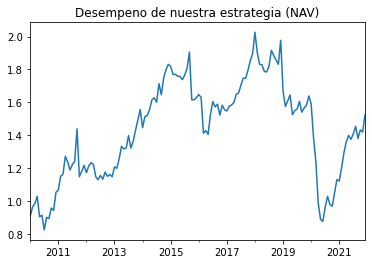

In [8]:
# Primero que todo, creamos nuestro DataFrame vacio donde vamos a guardar los resultados
pesos_etf = pd.DataFrame(index=fechas_rebalanceo, columns=px_etf.columns)

mapa_pesos = {
    1: .1,  # Peso asignado en caso de senal de compra
    0: 0,  # Posicion cerrada
    -1: -.1  # Peso asignado en caso de senal de venta
}

# Pasamos de senales a pesos
for dt in fechas_rebalanceo:
    senales_t = senales_etf.loc[dt]  # Senales de inversion
    w_t = senales_t.map(mapa_pesos)  # Pesos de mi portafolio ese dia (version pro)
    pesos_etf.loc[dt] = w_t  # Almaceno mi portafolio en el DataFrame de resultados

'''
Nota
----
El metodo .resample() nos ayuda a bajar la frecuencia de muestreo de un DataFrame que 
tiene un indice temporal (ej. pasar de data diaria a semanal). Las frecuencias mas comunes
incluyen:
    - M: Ultimo dia del mes (sea dia habil o no)
    - W: Cada domingo
    - Q: Fin de trimestre

Despues de utilizar resample, se debe especificar la funcion con la que se debe hacer el
muestreo. Usualmente usamos .last() para tomar la ultima observacion del periodo de muestreo.
'''
    
# Calculamos los retornos historicos mensuales
rt_etf_mensual = px_etf.resample('M').last().pct_change().reindex(fechas_rebalanceo)

# Retornos de nuestro portafolio
r_p = pesos_etf.shift(1).mul(rt_etf_mensual).dropna().sum(axis=1)

# De retornos a precios (NAV)
nav = r_p.add(1).cumprod()
nav.plot(title='Desempeno de nuestra estrategia (NAV)')

#### 4.3 Calibracion

Utilice una grilla de busqueda para segurir otros valores de I y L que mejoren la estrategia.
Justique su respuesta con comentarios dentro del codigo.